In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image, plot_prediction
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *
from utils.evaluation import SingleImageCOCOEvaluator


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import umap


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env					notebooks
acdc_large_cls_test_slim_coco_format.json	output
acdc_large_cls_test_slim_coco_format.json.lock	pipeline_configs
al_output					README.md
coco_instances_results.json			requirements.txt
data						shell_scripts
experiments					src
instances_predictions.pth			utils
local						wandb
log


In [9]:
logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

register_datasets()
ds_json = DatasetCatalog.get(get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
))


cfg = get_config("acdc_large_al")
cfg.OUTPUT_DIR = "./output/default_acdc_large_full_dssss"
cfg.AL.OBJECT_TO_IMG_AGG = "mean"


model_path = "/home/florian/GitRepos/activeCell-ACDC/output"

###########################################
do_inference = True
offs = 10 # size of used feature map center +- offs

###########################################


id_pool = ds_json


def get_latent():
    model = load_model(
        cfg,
        os.path.join(model_path, f"best_model.pth"),
    )
    model.eval()

    #checkpointer = DetectionCheckpointer(model)
    #checkpointer.load(os.path.join(cfg.OUTPUT_DIR, "best_model.pth"))



    if do_inference:
        feature_vector =  []
        for im_json in tqdm(id_pool):
            #im_json = list(filter(lambda x: x["image_id"] == id, ds_json))[0]
            input_image = cv2.imread(im_json["file_name"])

            aug = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )

            height, width = input_image.shape[:2]
            image = aug.get_transform(input_image).apply_image(input_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = [{"image": image, "height": height, "width": width}]

            images = model.preprocess_image(inputs)
            features = model.backbone(images.tensor)

            x_1, x_2 = features["p5"].shape[2], features["p5"].shape[3]

            
            feature_vector.append(features["p5"].to("cpu").detach().numpy()[:,:,int(x_1/2)-offs:int(x_1/2)+offs,int(x_2/2)-offs:int(x_2/2)+offs].flatten())



        mat = np.stack(feature_vector)
        np.savez_compressed("experiments/results/active_learning_vis/latent_space.npz", mat)
        
    else:
        
        mat = np.load("experiments/results/active_learning_vis/latent_space.npz")["arr_0"]

registering acdc_large dataset
registering acdc_large_cls dataset


In [2]:
mat = np.load("experiments/results/active_learning_vis/latent_space.npz")["arr_0"]

In [3]:
mat

array([[ 0.15983546,  0.21288091,  0.22192572, ..., -0.25695777,
        -0.17685759,  0.02483583],
       [ 0.19212228,  0.2270679 ,  0.21076897, ..., -0.23477973,
        -0.13879216, -0.00201706],
       [ 0.17198381,  0.20710047,  0.21664633, ..., -0.2676434 ,
        -0.08353238,  0.00097036],
       ...,
       [ 0.08358419,  0.10819529,  0.0859267 , ..., -0.06946251,
        -0.02599161, -0.01811934],
       [ 0.11043765,  0.161092  ,  0.15385261, ..., -0.07956839,
        -0.10380875, -0.1270202 ],
       [ 0.10371377,  0.08723997,  0.06557824, ..., -0.15262608,
        -0.01820105, -0.01189131]], dtype=float32)

In [32]:
umap_embedding = umap.UMAP(random_state=42, min_dist=0.7, n_neighbors=300, n_components=2).fit_transform(mat)

/home/florian/GitRepos/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [36]:
df = pd.DataFrame({
    "id":[im_json["image_id"] for im_json in id_pool],
    "umap_dim_0":umap_embedding[:, 0],
    "umap_dim_1":umap_embedding[:, 1],
})
df["position"] = df["id"].str.split("_").str[:-1].str.join("_")

In [37]:
df.head()

,id,umap_dim_0,umap_dim_1,position
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,-9.630236,-2.314349,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,-9.548872,-2.178212,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,-9.905873,-2.298554,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,-7.641358,-0.534689,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,-7.645915,-0.639686,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...


/tmp/ipykernel_9301/944294525.py:2: UserWarning: 
The palette list has fewer values (10) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<AxesSubplot: xlabel='umap_dim_0', ylabel='umap_dim_1'>

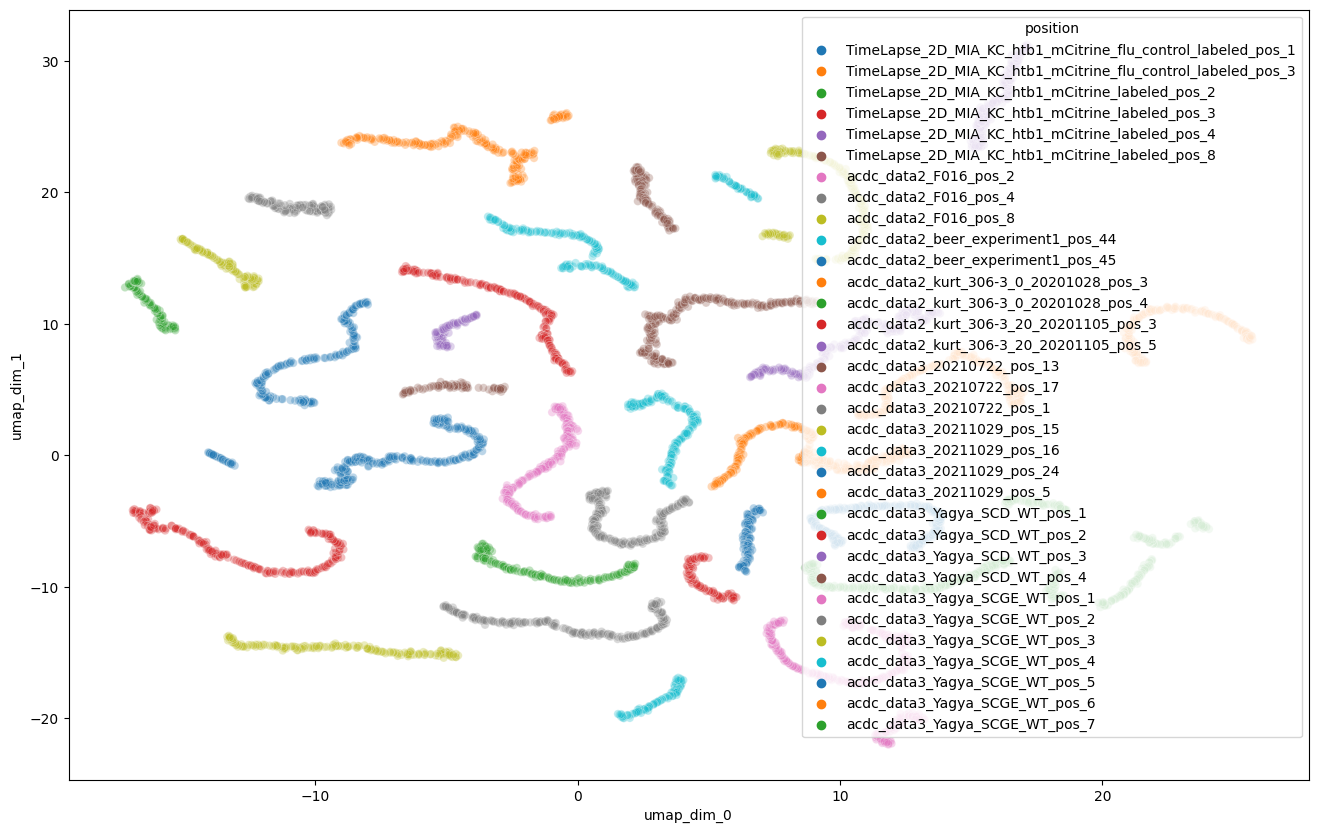

In [42]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap_dim_0", y="umap_dim_1",
    hue="position",
    palette=sns.color_palette("tab10"), # ("ch:s=.25,rot=-.25", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)